תרגיל - ניתוח טקסט - סיווג סנטימנט

מטרת התרגיל היא לסווג סנטימנט שלילי/חיובי מתוך תגובות בדף הפייסבוק של הנשיא ריבלין.
ראשית, יש להיכנס לקישור הבא:
https://github.com/omilab/Neural-Sentiment-Analyzer-for-Modern-Hebrew
בקישור הנ״ל אפשר למצוא שני jupyter notebooks שבשלב זה לא רלוונטיים, אפשר להתעלם מהן. מה שכן נדרש שקריאת ההסבר בקובץ readme וקריאת המאמר עצמו. 
לאחר השלמת החלק התיאורטי, נדרש לכתוב מסווג פשוט המבוסס על TF-IDF אך לא רק ואפשר להשתמש ברעיונות נוספים כמו למשל POS. הרעיון, לממש מסווג פשוט ולא רשתות עמוקות, למשל אפשר להשתמש ב-Logistic Regression Classifier.


References
Introduction to Information Retrieval
Tf-idf weighting
How to Use Tfidftransformer & Tfidfvectorizer - A Short Tutorial
sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.24.2 documentation


In [2]:
import codecs
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from nltk.tokenize import TreebankWordTokenizer
import emoji
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
def extract_emojis(text):
  return ''.join(c for c in text if c in emoji.UNICODE_EMOJI['en'])

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

In [5]:
def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

# Loading the data

In [ ]:
def load_data(filename):
    data = list(codecs.open(filename, 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    # Reducing any char-acter sequence of more than 3 consecutive repetitions to a respective 3-character sequence 
    # (e.g. “!!!!!!!!”turns to “!!!”)
    # x = [re.sub(r'((.)\2{3,})', r'\2\2\2', i) for i in x]
    x = np.asarray(list(x))
    y = np.array(y).astype(np.int)
    #y = to_categorical(y, 3)
    
    
    return x, y

In [41]:
x_token_train, y_token_train = load_data('data/token_train.tsv')
x_token_test, y_token_test = load_data('data/token_test.tsv')
x_morph_train, y_morph_train = load_data('data/morph_train.tsv')
x_morph_test, y_morph_test = load_data('data/morph_test.tsv')


In [64]:
# putting in dataframe

train_df = pd.DataFrame()
train_df["x_token_train"] = x_token_train
train_df["y_token_train"] = y_token_train
train_df["x_morph_train"] = x_morph_train
train_df["y_morph_train"] = y_morph_train

test_df = pd.DataFrame()
test_df["x_token_test"] = x_token_test
test_df["y_token_test"] = y_token_test
test_df["x_morph_test"] = x_morph_test
test_df["y_morph_test"] = y_morph_test


# EDA

## train_df

In [66]:
train_df.head(15)

,x_token_train,y_token_train,x_morph_train,y_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,0
1,איש יקר שלנו,0,איש יקר של אנחנו,0
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,0
5,רובי חג שמח והצלחה בבחירות לנשיאות .,0,רובי חג שמח ו הצלחה ב בחירות ל ה נשיאות .,0
6,הנשיא לא נותן יד . דיי להתלהמות אפשר להביע דיע...,0,ה נשיא לא נותן יד . די אני ל התלהמות אפשר להבי...,0
7,כבוד הנשיא אין מתאים ממך בעולם מלהיות נשיא מדי...,0,כבוד ה נשיא אין מתאים מן אתה ב ה עולם מ להיות ...,0
8,""" כל הכבוד לך אדוני הנשיא כאיש ימין דווקא , אנ...",0,""" כל ה כבוד ל אתה אדוני ה נשיא כ איש ימין דווק...",0
9,אדוני הנשיא סליחה על הבוטות תפסיק לזיין את השכ...,1,אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה...,1


<AxesSubplot:ylabel='y_token_train'>

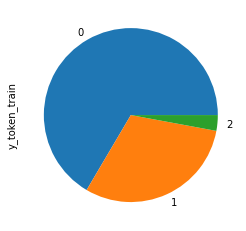

In [67]:
train_df.y_token_train.value_counts().plot(kind ='pie')

In [68]:
train_df.corr()

,y_token_train,y_morph_train
y_token_train,1.0,1.0
y_morph_train,1.0,1.0


In [70]:
train_df[train_df.y_token_train == 0][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,0
1,איש יקר שלנו,0,איש יקר של אנחנו,0
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,0


In [71]:
train_df[train_df.y_token_train == 1][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
9,אדוני הנשיא סליחה על הבוטות תפסיק לזיין את השכ...,1,אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה...,1
11,ואני עוד חשבתי שהגיע נשיא נורמלי,1,ו אני עוד חשבתי ש הגיע נשיא נורמלי,1
12,נשיא המדינה הלבן והמנותק חכם בדיבורים . הוא לא...,1,נשיא ה מדינה ה לבן ו ה מנותק חכם ב ה דיבורים ....,1
14,""" רובי ריבלין היקר !! אתה איש משפחה לא ???.. מ...",1,""" רובי ריבלין ה יקר !! אתה איש משפחה לא ???.. ...",1
18,עוד לא שבוע בתפקיד וכבר שכחת מאיפה באת ?,1,עוד לא שבוע ב ה תפקיד ו כבר שכחת מ איפה באת ?,1


In [72]:
train_df[train_df.y_token_train == 2][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
53,חייבים לעשות סוג של חרם כשכתבים שונאי ישראל עו...,2,חייבים לעשות סוג של חרם כש כתבים שונאי ישראל ע...,2
78,אז אתה בא ? https://www.facebook.com/events/15...,2,אז אתה בא ? https://www.facebook.com/events/15...,2
82,""" גאי אתה טיפש מטופש ילד כאפות שלא חונך על ברכ...",2,""" גאי אתה טיפש מטופש ילד כאפות ש לא חונך על בר...",2
117,שמעון יפרח העלאתי בשבילך את דבריו של שמעון פרס...,2,ש מעון יפרח העלאתי בשביל אתה את דבריו של שמעון...,2
181,רובי ריבלין הנשיא העשירי תחזית שניתנה לפני הבח...,2,רובי ריבלין ה נשיא ה עשירי תחזית ש ניתנה לפני ...,2


In [ ]:
The dataset contains:
1. **x_token_train** - collection of talkback as strings
2. **y_token_train** - Sentiment classification (target), (0 - Positive, 1 - Negtive, 2 - Neutral)
3. x_morph_train - same as x_token_train, but seperated to prefix, nuclear word, suffix (morphologically rich language)
4. y_morph_train - same as y_token_train, since it is the same sentiment

In [ ]:
morph examples:    

    לנשיאות
    ל ה נשיאות

    לה הצלחה
    ל היא הצלחה

In [ ]:
The y variables are the sentiment:


# morph_train_df

In [61]:
morph_train_df.head(15)

,x_morph_train,y_token_test
0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,0
1,איש יקר של אנחנו,0
2,כל ה כבוד ו המון ב הצלחה,0
3,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",0
4,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,0
5,רובי חג שמח ו הצלחה ב בחירות ל ה נשיאות .,0
6,ה נשיא לא נותן יד . די אני ל התלהמות אפשר להבי...,0
7,כבוד ה נשיא אין מתאים מן אתה ב ה עולם מ להיות ...,0
8,""" כל ה כבוד ל אתה אדוני ה נשיא כ איש ימין דווק...",0
9,אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה...,1


In [44]:
token_test_df.describe()

,y_token_test
count,2560.000000
mean,0.364844
std,0.536745
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [16]:
x_token_train[:15]

array(['ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד צער',
       'איש יקר שלנו', 'כל הכבוד והמון בהצלחה',
       '" תל חי , רובי . בכל העצב הזה היית קרן אור של תקוה . אכן יש נשיא בישראל "',
       'נקי כפיים ובר לבב בהצלחה לך ולנו .',
       'רובי חג שמח והצלחה בבחירות לנשיאות .',
       'הנשיא לא נותן יד . דיי להתלהמות אפשר להביע דיעה ולהתנגד אך לא פיזית . זו הבחירה שלה להנשא למוסלמי . נאחל לה הצלחה !',
       'כבוד הנשיא אין מתאים ממך בעולם מלהיות נשיא מדינת ישראל עם ישראל אוהב אותך והקב ׳ ה אוהב אותך ואתה דוגמה ומופת לכל אדם באשר הוא אני מאחל לך אושר עושר ובריאות איתנה עד 120 ועוד',
       '" כל הכבוד לך אדוני הנשיא כאיש ימין דווקא , אני חושב שאהבה תנצח . "',
       'אדוני הנשיא סליחה על הבוטות תפסיק לזיין את השכל . עד היום לא התבטאת ולו במילה על המצב במדינה . לא הבעת את אהדתך לצבא . לא אמרת מילה טובה ומעודדת לתושבי הדרום . אם חשוב לך תשעה באב אז תחזור להסטוריה ותעלם מעינינו .',
       'בהצלחה אדוני הנשיא', 'ואני עוד חשבתי שהגיע נשיא נורמלי',
       'נשיא המדינה הלבן והמנותק חכם 

In [17]:
y_token_train[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1])

In [18]:
x_morph_train[:15]

array(['ממש כואב ..... אני בכה את היא עם ה משפחה ש לא תדעו עוד צער',
       'איש יקר של אנחנו', 'כל ה כבוד ו המון ב הצלחה',
       '" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור של תקוה . אכן יש נשיא ב ישראל "',
       'נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .',
       'רובי חג שמח ו הצלחה ב בחירות ל ה נשיאות .',
       'ה נשיא לא נותן יד . די אני ל התלהמות אפשר להביע דיעה ו להתנגד אך לא פיזית . זו ה בחירה של היא להנשא ל ה מוסלמי . נאחל ל היא הצלחה !',
       'כבוד ה נשיא אין מתאים מן אתה ב ה עולם מ להיות נשיא מדינת ישראל עם ישראל אוהב את אתה ו ה קב ׳ ה אוהב את אתה ו אתה דוגמה ו מופת ל כל אדם באשר הוא אני מאחל ל אתה אושר עושר ו בריאות איתנה עד 120 ו עוד',
       '" כל ה כבוד ל אתה אדוני ה נשיא כ איש ימין דווקא , אני חושב ש אהבה תנצח . "',
       'אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה שכל . עד היום לא התבטאת ו לו ב מילה על ה מצב ב ה מדינה . לא ה בעת את אהדתך ל ה צבא . לא אמרת מילה טובה ו מעודדת ל תושבי ה דרום . אם חשוב ל אתה תשעה ב ה אב אז תחזור ל ה הסטוריה ו תעלם מ עינינו 

In [19]:
y_morph_train[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1])

In [21]:
y_diff = y_token_train - y_morph_train

In [30]:
print(y_diff.sum())
print(y_diff.min())
print(y_diff.max())

0
0
0


The morph data is the same as the token data, it is just seperated to the prefix, nuclear word, suffix:
1. example 1:
לנשיאות
ל ה נשיאות

2. example 2:
לה הצלחה
ל היא הצלחה

The y variables are the sentiment:

In [33]:
np.unique(y_morph_train)

array([0, 1, 2])

Which repesent the sentiment:
0 - Positive
1 - Negtive
2 - Neutral

In [32]:
stop_words =[]
with open('hebrew_stop_words.json', 'r') as f:
    stop_words = json.load(f)

In [ ]:
# prepare the courpus

tokenizer = TreebankWordTokenizer()

train_df = pd.DataFrame()
train_df["text"] = x_token_train;

train_df["emoji"] = train_df.text.map(lambda x: set(extract_emojis(x)))

train_df["clean_text"] = train_df.text.map(lambda x: remove_URL(x))
train_df["clean_text"] = train_df.text.map(lambda x: remove_html(x))
train_df["clean_text"] = train_df.text.map(lambda x: remove_emoji(x))
train_df["clean_text"] = train_df.text.map(lambda x: remove_punct(x))

train_df["clean_tokens"] = train_df.clean_text.map(tokenizer.tokenize)

train_df["target"] = y_token_train


In [ ]:
train_df.info()

In [ ]:
from wordcloud import WordCloud

In [ ]:
bd_hsw = get_display(" ".join(stop_words)).split(" ")

In [ ]:


all_words_wc = WordCloud(
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    stopwords=bd_hsw,
    max_words=30,
    max_font_size=80).generate(get_display(all_clean_words))

plt.figure(figsize=(16, 8))
plt.imshow(all_words_wc, )

In [ ]:
# Divide the corpus to negative and positive

positive_df = train_df[train_df["target"] == 0]
negative_df = train_df[train_df["target"] == 1]

all_positive_wc = WordCloud(
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    stopwords=bd_hsw,
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(positive_df.clean_text)))

all_negative_wc = WordCloud(
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    stopwords=bd_hsw,
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(negative_df.clean_text)))

plt.figure(1, figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("positive")
plt.imshow(all_positive_wc)

plt.subplot(1, 2, 2)
plt.title("negative")
plt.imshow(all_negative_wc)


In [ ]:
Bag of words

In [ ]:
train_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def count_vect(data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [ ]:
train_counts, count_vectorizer = count_vect(train_df["clean_text"])
test_counts = count_vectorizer.transform(x_token_test)

In [ ]:
type(train_counts)

In [ ]:
train_counts.todense().shape

In [ ]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [ ]:
print(train_counts.todense()[0][0:].sum())

In [ ]:
train_counts, count_vectorizer = count_vect(train_df.clean_text, ngrams=(1, 2))
test_counts = count_vectorizer.transform(x_token_test)

In [ ]:
print(train_counts.todense()[0][0:].sum())

In [ ]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train_df.clean_text)
test_tfidf = tfidf_vectorizer.transform(x_token_test)

In [ ]:
[x for x in train_tfidf.todense()[0][0:].tolist()[0] if x != 0]

In [ ]:
print(train_tfidf.todense()[0][0:].sum())

In [ ]:
rain_tfidf, tfidf_vectorizer = tfidf(train_df.clean_text, ngrams=(1, 2))
test_tfidf = tfidf_vectorizer.transform(x_token_test)

In [ ]:
print(train_tfidf.todense()[0][0:].sum())

In [ ]:
X_counts = train_counts
X_tfidf = train_tfidf
y = y_token_train

In [ ]:
type(y)

In [ ]:
# TF IDF

In [ ]:
test_df = pd.DataFrame()
test_df["text"] = x_token_test;


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train_df.clean_text)
test_tfidf = tfidf_vectorizer.transform(test_df["text"])

In [ ]:
type(train_df.clean_text)

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train_df["clean_text"])

In [ ]:
X = train_tfidf
y = y_token_train

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

In [ ]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
X_test

In [ ]:
y_pred

In [ ]:
(1 - abs((y_test - y_pred).sum() / len(y_pred))) * 100

In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Tfidf Model Score: {f1score * 100} %")

In [ ]:
test_dfidf = 